In [60]:
import numpy as np
import pylab as pl

from   astropy.table import Table

In [26]:
dat = Table.read('/global/cscratch1/sd/mjwilson/secondary/sv1/raw/Mar21/LBG_LBGLAE.fits')

In [27]:
dat.pprint()

   ID           RA                DEC         MASK ... H_ERR     KS   KS_ERR
------- ------------------ ------------------ ---- ... ------ ------- ------
2583147 150.75933271574516  0.983195946873128    0 ... 1000.0 -99.008 1000.0
 573916 150.86911633369758  3.426048659419034    0 ... 1000.0 -99.006 1000.0
2780988 149.50564681564768   1.85035147374792    0 ...  0.038  22.842  0.031
 531718  150.7392966994768 3.0388757335261487    0 ... 1000.0 -99.007 1000.0
4284702  150.1982722567504  2.540242923257786    0 ...  0.017  21.643  0.019
3304418 148.88704835035935  2.860288849123229    0 ... 1000.0 -99.008 1000.0
4867461  149.4769176608476 2.7146748082853858    0 ...   0.08   22.03   0.28
5242180 151.10482625165122  2.821128757377072    0 ... 1000.0 -99.009 1000.0
2604067 150.77116917897175 1.2011132416614745    0 ... 1000.0 -99.008 1000.0
3913049  150.7108549121019  2.544422091021527    0 ...  0.001  18.408  0.002
    ...                ...                ...  ... ...    ...     ...    ...

In [28]:
dat

ID,RA,DEC,MASK,FLAG_FIELD,FLAG_FIELD_BINARY [7],EB_V,FUV_err,NUV_err,MAG_ABS_FUV,MAG_ABS_NUV,MAG_ABS_u,MAG_ABS_uS,MAG_ABS_g,MAG_ABS_r,MAG_ABS_i,MAG_ABS_z,MAG_ABS_y,MAG_ABS_Yv,MAG_ABS_J,MAG_ABS_H,MAG_ABS_Ks,Z_SPEC,Z_BEST,NBAND_USED,CHI_BEST,CHI_STAR,CHI_QSO,MOD_BEST,MOD_STAR,MOD_QSO,Z_ML,Z_ML68_LOW,Z_ML68_HIGH,Z_SEC,Z_QSO,Z_BC03,ZPHOT,MOD_BEST_BC03,PRIORITY,TILEID,SAMPLE,TARGETID,SUBPRIORITY,PMRA,PMDEC,REF_EPOCH,OVERRIDE,U,U_ERR,US,US_ERR,G,G_ERR,R,R_ERR,I,I_ERR,Z,Z_ERR,Y,Y_ERR,YV,YV_ERR,J_ERR,H_ERR,KS,KS_ERR
int64,float64,float64,int16,int16,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int32,bytes9,int64,float64,float32,float32,float32,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2583147,150.75933271574516,0.983195946873128,0,7,True .. False,0.020819177342490044,-99.0,-99.0,-13.69,-13.808,-14.48,-14.7,-15.219,-15.461,-15.581,-15.644,-15.699,-15.714,-15.717,-15.828,-15.589,-99.0,0.02,11,8.99221,50.9027,54.8312,2,49,1,0.0426,0.0069,0.0694,-99.0,0.04,0.0426,0.0426,2,10000,2068,CLAUDS-BX,4339,0.8743910704931016,0.0,0.0,0.0,False,22.057,0.0,21.957,0.006,21.166,0.001,20.873,0.001,20.758,0.002,20.693,0.002,20.675,0.005,-99.025,1000.0,1000.0,1000.0,-99.008,1000.0
573916,150.86911633369758,3.426048659419034,0,7,True .. False,0.017170668097478598,-99.0,-99.0,-11.494,-13.077,-15.089,-15.398,-16.249,-16.484,-16.555,-16.717,-16.782,-16.799,-16.813,-16.943,-16.715,-99.0,0.0834,11,279.852,105.382,39.3204,2,63,30,0.08,0.0664,0.0936,-99.0,3.08,0.08,0.08,1,10000,39966,CLAUDS-U,109,0.307109878015725,0.0,0.0,0.0,False,23.183,0.005,22.978,0.012,21.631,0.002,21.278,0.002,21.216,0.002,21.093,0.002,21.007,0.005,-99.021,1000.0,1000.0,1000.0,-99.006,1000.0
2780988,149.50564681564768,1.85035147374792,0,95,True .. True,0.017389397440208332,-99.0,-99.0,-22.063,-22.078,-22.229,-22.387,-22.964,-22.988,-23.023,-23.097,-23.148,-23.158,-23.136,-23.207,-22.948,-99.0,3.3102,11,12.2932,353.556,34.894,2,143,24,3.2946,3.2518,3.328,-99.0,3.24,3.2946,3.2946,2,10000,11155,CLAUDS-U,119,0.11247313705618422,0.0,0.0,0.0,False,28.852,0.893,26.3,0.129,24.071,0.01,23.598,0.008,23.558,0.01,23.523,0.014,23.628,0.031,23.624,0.026,0.034,0.038,22.842,0.031
531718,150.7392966994768,3.0388757335261487,0,7,True .. False,0.0180709168628438,-99.0,-99.0,-13.7,-14.546,-15.959,-16.257,-17.069,-17.27,-17.305,-17.375,-17.44,-17.454,-17.452,-17.559,-17.326,-99.0,0.0635,11,269.345,73.1368,13.3639,1,51,30,0.06,0.0464,0.0736,-99.0,3.0,0.06,0.06,1,10000,34204,CLAUDS-U,118,0.6347785534909552,0.0,0.0,0.0,False,21.481,0.001,21.358,0.002,20.104,0.0,19.828,0.0,19.794,0.0,19.752,0.001,19.697,0.001,-99.022,1000.0,1000.0,1000.0,-99.007,1000.0
4284702,150.1982722567504,2.540242923257786,0,127,True .. True,0.015768861470084283,-99.0,-99.0,-23.224,-23.356,-23.632,-23.719,-24.03,-24.1,-24.183,-24.282,-24.332,-24.343,-24.374,-24.435,-24.16,-99.0,3.0909,11,19.9142,130.281,57.546,33,143,25,3.0902,3.0691,3.111,-99.0,3.3,3.0902,3.0902,10,10000,11155,CLAUDS-U,117,0.9673266517128524,0.0,0.0,0.0,False,25.181,0.126,24.395,0.047,22.894,0.012,22.337,0.009,22.201,0.009,22.168,0.014,22.234,0.028,22.383,0.016,0.018,0.017,21.643,0.019
3304418,148.88704835035935,2.860288849123229,0,3,True .. False,0.02280842908644172,-99.0,-99.0,-17.931,-18.62,-19.742,-19.966,-20.688,-21.127,-21.459,-21.717,-21.851,-21.895,-22.045,-22.298,-22.178,-99.0,0.3128,11,2.64537,124.341,9.10963,29,99,21,0.3136,0.2969,0.3328,-99.0,0.32,0.3136,0.3136,9,10000,39965,CLAUDS-U,116,0.6120128892578972,0.0,0.0,0.0,False,27.419,1000.0,27.713,1000.0,20.986,0.002,20.094,0.001,19.735,0.001,19.301,0.001,19.381,0.002,-99.028,1000.0,1000.0,1000.0,-99.008,1000.0
4867461,149.4769176608476,2.7146748082853858,0,31,True .. False,0.017

In [51]:
np.unique(dat['SAMPLE'], return_counts=True)

(<Column name='SAMPLE' dtype='bytes9' length=3>
 CLAUDS-BX
  CLAUDS-G
  CLAUDS-U,
 array([4952, 7071, 3651]))

(-1.0, 6.5)

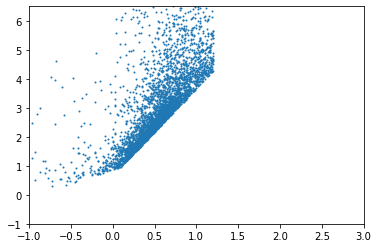

In [54]:
isin = dat['SAMPLE'] == 'CLAUDS-U'

pl.plot(dat['G'][isin] - dat['R'][isin], dat['U'][isin] - dat['R'][isin], marker='.', lw=0.0, markersize=2)

pl.xlim(-1., 3.0)
pl.ylim(-1., 6.5)

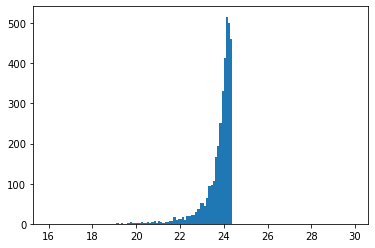

In [55]:
_ = pl.hist(dat['R'][isin], bins=np.arange(16., 30., 0.1))

(-1.0, 6.5)

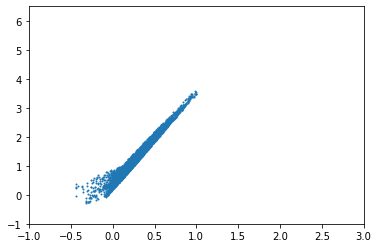

In [56]:
isin = dat['SAMPLE'] == 'CLAUDS-BX'

pl.plot(dat['G'][isin] - dat['R'][isin], dat['U'][isin] - dat['R'][isin], marker='.', lw=0.0, markersize=2)

pl.xlim(-1., 3.0)
pl.ylim(-1., 6.5)

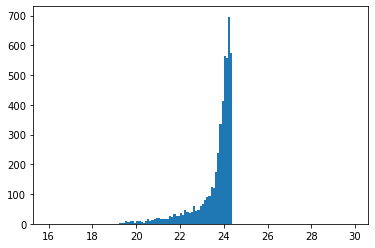

In [57]:
_ = pl.hist(dat['R'][isin], bins=np.arange(16., 30., 0.1))

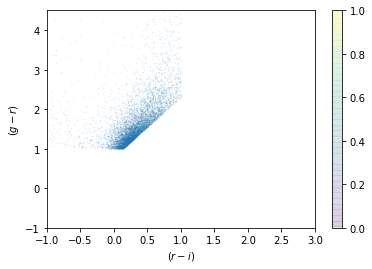

In [58]:
isin = dat['SAMPLE'] == 'CLAUDS-G'

pl.scatter(dat['R'][isin] - dat['I'][isin], dat['G'][isin] - dat['R'][isin], marker='.', alpha=0.1, label='', s=1)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(r-i)$')
pl.ylabel(r'$(g-r)$')

pl.colorbar()

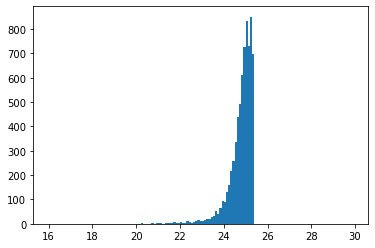

In [59]:
_ = pl.hist(dat['I'][isin], bins=np.arange(16., 30., 0.1))

In [49]:
len(dat)

15674

Text(0.5, 0, 'Z')

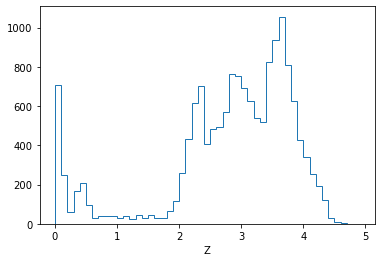

In [44]:
pl.hist(dat['Z_BC03'], bins=np.arange(0.0, 5.0, 0.1), histtype='step')

pl.xlabel('Z')